In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fiona
import collections
import matplotlib.pyplot as plt
import pyproj
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio import features
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date, timedelta
import geopandas
import os
from shapely import geometry
import numpy as np
import utilities
import pandas as pd
import shutil
import glob
pd.set_option('display.max_columns', None)
import time
import zipfile
import geopandas as gpd
import shapely
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon
from PIL import Image

In [3]:
# 18-21 Jul 2019
start_date = date.today() - timedelta(15)
end_date = date.today()

In [4]:
path = "/home/primity/terras/bulk/"
dest = "/home/primity/terras/bulk_crops/"

In [37]:
freguesias_shapes=gpd.read_file("gadm36_PRT_shp/gadm36_PRT_3.shp")
concelhos_shapes = gpd.read_file("gadm36_PRT_shp/gadm36_PRT_2.shp")
cardigos_shp = freguesias_shapes[freguesias_shapes.NAME_3=='Cardigos'].iloc[0].geometry
macao_shp = concelhos_shapes[concelhos_shapes.NAME_2=='Mação'].iloc[0].geometry

In [44]:
points_list = [(macao_shp.bounds[0], macao_shp.bounds[3]),
              (macao_shp.bounds[0], macao_shp.bounds[1]),
              (macao_shp.bounds[2], macao_shp.bounds[1]),
              (macao_shp.bounds[2], macao_shp.bounds[3])]
macao_outer_square = geometry.Polygon(points_list)

In [45]:
macao_shp.intersects(macao_outer_square)

True

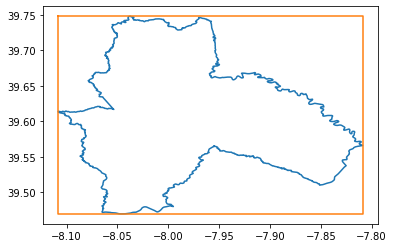

In [46]:
plt.plot(*macao_shp.exterior.xy)
plt.plot(*macao_outer_square.exterior.xy)

In [53]:
api = SentinelAPI('fernandeslouro', 'copernicospw', 'https://scihub.copernicus.eu/dhus')
products = api.query(macao_outer_square,
                     date=(date.today() - timedelta(7), date.today()),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30))
products_df = api.to_dataframe(products)
products_df['footprint'] = geopandas.GeoSeries.from_wkt(products_df['footprint'])
products_df = gpd.GeoDataFrame(products_df, geometry='footprint')
products_df['fully_contained'] = products_df.apply(lambda row: row.footprint.contains(macao_shp), axis=1)
products_df['intersection_area'] = products_df.apply(lambda row: macao_shp.intersection(row.footprint).area/macao_shp.area, axis=1)

In [58]:
products_df = products_df[products_df['intersection_area']>0.95]

In [61]:
len(products_df)

3

0.9996164580250373


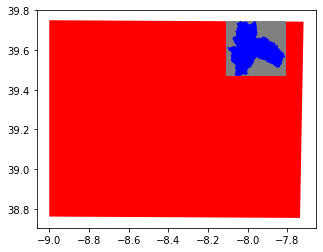

0.9996164580250373


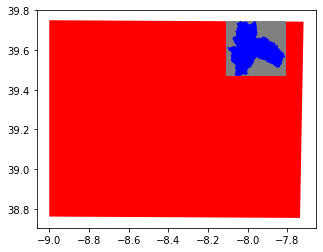

0.9996164580250373


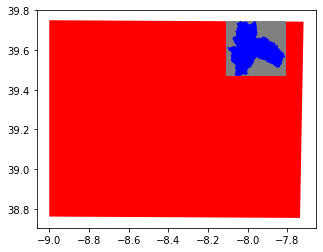

In [64]:
for polygon1 in list(products_df.footprint):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    gpd.GeoSeries(polygon1).plot(ax=ax, color='red')
    gpd.GeoSeries(macao_outer_square).plot(ax=ax, color='grey')
    gpd.GeoSeries(macao_shp).plot(ax=ax, color='blue')
    print(macao_shp.intersection(polygon1).area/macao_shp.area)
    plt.show()
    

In [69]:
products_df.sort_values('generationdate', ascending=False)

,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,illuminationazimuthangle,illuminationzenithangle,vegetationpercentage,notvegetatedpercentage,waterpercentage,unclassifiedpercentage,mediumprobacloudspercentage,highprobacloudspercentage,snowicepercentage,cloudcoverpercentage,level1cpdiidentifier,gmlfootprint,footprint,format,processingbaseline,platformname,filename,instrumentname,instrumentshortname,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,datatakesensingstart,sensoroperationalmode,tileid,hv_order_tileid,intersection_area
fa4a825f-4b66-403d-ad0a-acb9b9ecaf45,S2A_MSIL2A_20210603T112111_N0300_R037_T29SPD_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-06-03T11:21:11.024Z, Instrument: MS...",false,2021-06-03 14:42:54,2021-06-03 11:21:11.024,2021-06-03 11:21:11.024,2021-06-03 18:13:29.150,31065,37,140.345445,20.730126,32.551488,60.702354,0.361946,0.388230,0.233383,1.000581,0.000139,4.684922,S2A_OPER_MSI_L1C_TL_VGS2_20210603T133740_A0310...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-6.58624 38.73594, -6.55212 39...",SAFE,03.00,Sentinel-2,S2A_MSIL2A_20210603T112111_N0300_R037_T29SPD_2...,Multi-Spectral Instrument,MSI,1.12 GB,GS2A_20210603T112111_031065_N03.00,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20210603T144254_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20210603T144254_A0310...,S2A_MSIL2A_20210603T112111_N0300_R037_T29SPD_2...,fa4a825f-4b66-403d-ad0a-acb9b9ecaf45,NaT,NaN,NaN,NaN,0.022542
1e5ff63d-5c81-4b25-9cd3-2d3a6b4b5af0,S2A_MSIL2A_20210603T112111_N0300_R037_T29TNE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-06-03T11:21:11.024Z, Instrument: MS...",false,2021-06-03 14:42:54,2021-06-03 11:21:11.024,2021-06-03 11:21:11.024,2021-06-03 18:12:57.851,31065,37,139.282136,22.022937,53.339982,12.943730,9.155288,2.359979,3.246857,9.625801,0.067976,20.190281,S2A_OPER_MSI_L1C_TL_VGS2_20210603T133740_A0310...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-7.72037 39.65456, -7.70166 40...",SAFE,03.00,Sentinel-2,S2A_MSIL2A_20210603T112111_N0300_R037_T29TNE_2...,Multi-Spectral Instrument,MSI,1.11 GB,GS2A_20210603T112111_031065_N03.00,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20210603T144254_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20210603T144254_A0310...,S2A_MSIL2A_20210603T112111_N0300_R037_T29TNE_2...,1e5ff63d-5c81-4b25-9cd3-2d3a6b4b5af0,NaT,NaN,NaN,NaN,0.216276
0cffc8ec-55f2-4a82-99ae-02e72a046608,S2A_MSIL2A_20210603T112111_N0300_R037_T29SND_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-06-03T11:21:11.024Z, Instrument: MS...",false,2021-06-03 14:42:54,2021-06-03 11:21:11.024,2021-06-03 11:21:11.024,2021-06-03 18:12:15.388,31065,37,137.892773,21.320668,49.537754,24.710512,0.645841,0.583777,0.542298,0.417753,0.000020,23.846718,S2A_OPER_MSI_L1C_TL_VGS2_20210603T133740_A0310...,"<gml:Polygon srsName=""http://www.opengis.net/g...","MULTIPOLYGON (((-7.73660 38.75404, -7.71872 39...",SAFE,03.00,Sentinel-2,S2A_MSIL2A_20210603T112111_N0300_R037_T29SND_2...,Multi-Spectral Instrument,MSI,1.10 GB,GS2A_20210603T112111_031065_N03.00,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20210603T144254_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20210603T144254_A0310...,S2A_MSIL2A_20210603T112111_N0300_R037_T29SND_2...,0cffc8ec-55f2-4a82-99ae-02e72a046608,NaT,NaN,NaN,NaN,0.999616
28199f48-197f-44ca-b927-df185a0fdddd,S2A_MSIL2A_20210603T112111_N0300_R037_T29TPE_2...,https://scihub

In [ ]:
os.makedirs(path, exist_ok=True)
os.makedirs(dest, exist_ok=True)

#get products list from this day
api = SentinelAPI('fernandeslouro', 'copernicospw', 'https://scihub.copernicus.eu/dhus')
products = api.query(macao_outer_square,
                     date=(date.today() - timedelta(7), date.today()),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 30))
products_df = api.to_dataframe(products)

if products_df.empty:
    print('No images found')
else:    
    utilities.download_most_recent_product(products_df, polygon_to_overlap=macao_shp, path=path)


11 available products
Trying to download 0cffc8ec-55f2-4a82-99ae-02e72a046608


Downloading:   3%|▎         | 39.8M/1.19G [00:37<20:21, 938kB/s] 

In [ ]:
im=Image.fromarray(out_image)
im.save("your_file.png")

In [ ]:
# copy jp2 to dest
utilities.subfolders_copy(os.path.join(path, to_download['title'] + '.SAFE'), dest)

# save cropped jp2 with same name 
for i in utilities.listdir_nohidden(dest):
    with rasterio.open(os.path.join(dest, i)) as src:
        out_image, out_transform = rasterio.mask.mask(src, utilities.transform_shapefile(macao_shp), crop=True, nodata=0, all_touched=True)
        out_meta = src.meta.copy() 
        
    #with rasterio.open(os.path.join(dest, i)[:-4]+'.png','w',
    #                   driver='PNG',
    #                   height=out_image.shape[1],
    #                   width=out_image.shape[2],
    #                   dtype=rasterio.uint8,
    #                   count=out_image.shape[0],
    #                   compress='lzw') as dst:
    #    dst.write(np.array(out_image, dtype='uint8'))
    im=Image.fromarray(out_image)
    im.save("your_file.png")
for f in utilities.listdir_nohidden(dest):
    if '.jp2' in f and not f.startswith('.'):
        os.remove(os.path.join(dest, f))

#for f in glob.glob(os.path.join(path, to_download['title'])):
#    os.remove(f)
 

In [ ]:
plt.figure(figsize=(20,20))
plt.title(f'{np.array(out_image).shape} - {i}')
#plt.save(i)
out_image = (out_image-out_image.min())/(out_image.max()-out_image.min())
show(out_image)
